In [1]:
import pandas as pd
import numpy as np
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')
sample_submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)

                          결손값 개수  결손값_ratio
Delay                     744999   0.744999
Destination_State         109079   0.109079
Estimated_Arrival_Time    109040   0.109040
Estimated_Departure_Time  109019   0.109019
Origin_State              109015   0.109015
Carrier_ID(DOT)           108997   0.108997
Carrier_Code(IATA)        108990   0.108990
Airline                   108920   0.108920
Cancelled                      0   0.000000
Diverted                       0   0.000000
Origin_Airport                 0   0.000000
Origin_Airport_ID              0   0.000000
Month                          0   0.000000
Destination_Airport            0   0.000000
Destination_Airport_ID         0   0.000000
Day_of_Month                   0   0.000000
Distance                       0   0.000000
Tail_Number                    0   0.000000
ID                             0   0.000000
                          결손값 개수  결손값_ratio
Estimated_Arrival_Time    109048   0.109048
Carrier_ID(DOT)           109006

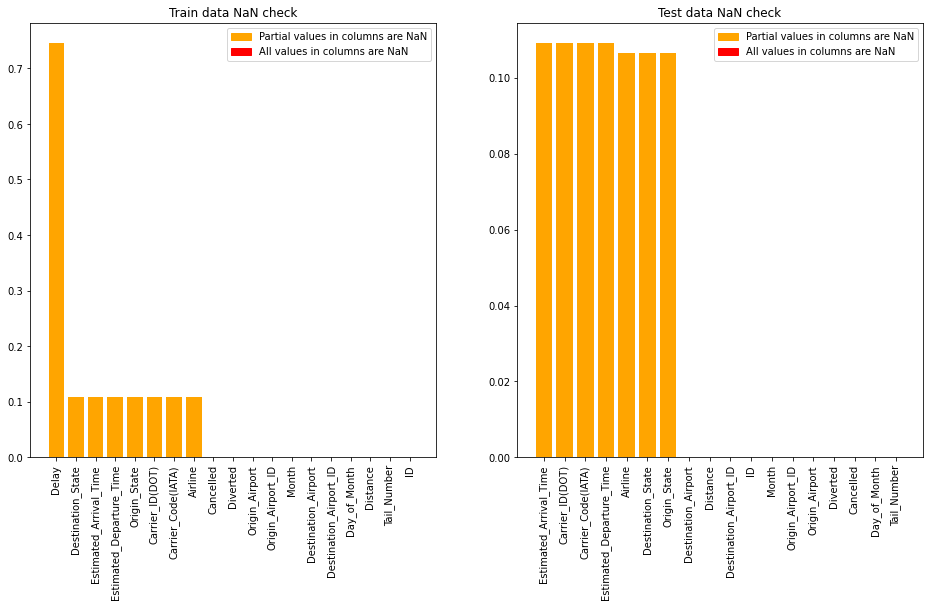

In [3]:
import matplotlib

# matplotlib.rcParams['font.family'] = 'NanumBarunGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

column = ['결손값 개수']
axis_1 = pd.DataFrame(data = train.isnull().sum(axis=1), columns = column)
axis_1 = axis_1.sort_values(by = '결손값 개수', ascending = False)

train.isnull().sum(axis=0)
train_row_NaN = pd.DataFrame(train.isnull().sum(axis=0), columns = column)
train_row_NaN = train_row_NaN.sort_values(by = '결손값 개수', ascending = False)
train_row_su = train.shape[0]
train_row_NaN['결손값_ratio'] = train_row_NaN['결손값 개수']/train_row_su

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize = (16,8))
x = np.arange(len(train_row_NaN.index))
plt.subplot(1, 2, 1)
plt.xticks(x, train_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])

def color(data):
    if data == 1:
        return 'red'
    else:
        return 'orange'
plt.bar(x, train_row_NaN['결손값_ratio'], color = [color(i) for i in train_row_NaN['결손값_ratio']])
plt.title('Train data NaN check')

test.isnull().sum(axis=0)
test_row_NaN = pd.DataFrame(test.isnull().sum(axis=0), columns = column)
test_row_NaN = test_row_NaN.sort_values(by = '결손값 개수', ascending = False)
test_row_su = test.shape[0]
test_row_NaN['결손값_ratio'] = test_row_NaN['결손값 개수']/test_row_su

plt.subplot(1, 2, 2)
x2 = np.arange(len(test_row_NaN.index))
plt.xticks(x2, test_row_NaN.index)
plt.xticks(rotation=90)
plt.legend(handles=[mpatches.Patch(color='orange'),
                    mpatches.Patch(color='red')], 
           labels=['Partial values in columns are NaN', 'All values in columns are NaN'])
plt.bar(x2, test_row_NaN['결손값_ratio'], color = [color(i) for i in test_row_NaN['결손값_ratio']])
plt.title('Test data NaN check')

print(train_row_NaN)
print(test_row_NaN)
plt.show()

In [4]:
# 준지도 학습 전 라벨링
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
 
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

label_st = train_lb.drop(columns = ['Airline'])
train_st = train_lb[(train_lb['Airline'].astype(str) != 'None')].drop(columns = ['Airline'])
X_nan = train_lb[(train_lb['Airline'].astype(str) == 'None')].drop(columns = ['Airline'])
test_nan = test_lb[(test_lb['Airline'].astype(str) == 'None')|(test_lb['Airline'].astype(str) == 'nan')].drop(columns = ['Airline'])

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport', 'Origin_State', 'Destination_Airport', 'Destination_State', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [5]:
# Airline self_training
original_col = ['Cancelled','Diverted','Origin_Airport','Origin_Airport_ID', 'Origin_State', 'Destination_Airport', 'Destination_Airport_ID', 'Destination_State', 'Tail_Number', 'Month', 'Day_of_Month','Distance']

X = train_st[original_col]
y = train_lb[(train_lb['Airline'].astype(str) != 'None')][original_col + ['Airline']]['Airline']

stclf = SelfTrainingClassifier(
    base_estimator = RandomForestClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)   

KeyboardInterrupt: 

In [ ]:
# 결과값 삽입

X_nan['Airline_pred'] = stclf.predict(X_nan[original_col])
test_nan['Airline_pred'] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb['Airline'].astype(str) == 'None', 'Airline'] = X_nan['Airline_pred']
test_lb.loc[test_lb['Airline'].astype(str) == 'None', 'Airline'] = test_nan['Airline_pred']